In [1]:
import numpy as np
import pandas as pd
#import h5py
import datetime
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# use the newest version with all data
mat_data = loadmat('/Volumes/XiYangBackUp/Projects/6.CalDrought/spatialvariation_12192020_1.mat')

bfast_dict = {}

col_names = ['PPTano_preBP', 'TMPano_preBP', 'VPDano_preBP',
             'PPTano_BP0',   'TMPano_BP0',   'VPDano_BP0',
             'PPTano_BP',    'TMPano_BP',    'VPDano_BP',
             'PPTano_BP4',   'TMPano_BP4',   'VPDano_BP4',
             'EVIano_BP',    'LC',            'WTD',          
             'EVI_BP',       'EVI_AVG',       'AWC',          
             'AWC_200',      'ALT',          'PPT_AVG',
             'TMP_AVG',      'VPD_AVG',      'SOIL_DEPTH',   
             'TMIN_AVG',     'PPTano_BP2',   'TMPano_BP2',   
             'VPDano_BP2',   'PPTano_2412',  'TMPano_2412',  'VPDano_2412',  'PPTano_1206',
             'TMPano_1206',  'VPDano_1206',  'PPTano_0606',
             'TMPano_0606',  'VPDano_0606',  'PPTano_0011',
             'TMPano_0011',  'VPDano_0011',  'PPTano_1201',
             'TMPano_1201',  'VPDano_1201',  'EVI_dev',
             'PPTano_2016',  'Tmano_2016', 'VPDano_2016',
             'PPTano_2017',  'Tmano_2017', 'VPDano_2017',
             'PPTano_2018',  'Tmano_2018', 'VPDano_2018',
             'PPTano_1618',  'Tmano_1618', 'VPDano_1618',
             'PPTano_3yr', 'Tmano_3yr', 'VPDano_3yr',
             'PPTano_dif', 'Tmano_dif', 'VPDano_dif',
             'PPTano_slp', 'Tmano_slp', 'VPDano_slp',
             'PPTano_pre', 'Tmano_pre', 'VPDano_pre',
             'PPTano_slp1', 'Tmano_slp1', 'VPDano_slp1',
             'Change_BP',  'slope1',
             'Change_preBP', 'Change_postBP', 'BP1', 'BP2','BP_Range','BP_num','Change_total']

for icol, col_name in enumerate(col_names):
        bfast_dict[col_name] = mat_data['All'][:,icol].tolist()

# convert land cover type to integer
bfast_dict['LC'] = [int(LC_val) for LC_val in bfast_dict['LC']]

# find whether there is only one BP (BP1 == BP2)
# find whether BP1 == BP2
#bfast_dict['is_BP1'] = [(bfast_dict['BP1'][i] - bfast_dict['BP2'][i]) < 1e-3 for i in
#                            np.arange(len(bfast_dict['BP1']))]
bfast_dict['is_BP1'] = 1 #always 1 or no so this one is not useful anymore

# convert BP1 to year with dot
bfast_dict['BP1_year'] = [
        (datetime.datetime(1,1,1) + datetime.timedelta(td-366-1)).timetuple().tm_year +
        (datetime.datetime(1,1,1) + datetime.timedelta(td-366-1)).timetuple().tm_yday / 366.
        for td in bfast_dict['BP1']
      ]

# save to csv
bfast_df = pd.DataFrame(bfast_dict)

# add new colums
bfast_df['Change_preBP'] = (bfast_df['Change_preBP'].values * 100.).tolist()
bfast_df['Change_BP'] = (bfast_df['Change_BP'].values * 100.).tolist()
bfast_df['Change_postBP'] = (bfast_df['Change_postBP'].values * 100.).tolist()
bfast_df['Change_total'] = (bfast_df['Change_total'].values * 100.).tolist()


bfast_df['Total_preBP'] = (0. + bfast_df['Change_preBP'].values ).tolist()
bfast_df['Total_BP'] = (bfast_df['Total_preBP'].values +
                               bfast_df['Change_BP'].values ).tolist()
bfast_df['Total_postBP'] = (bfast_df['Total_BP'].values +
                                   bfast_df['Change_postBP'].values).tolist()

bfast_df.to_csv('/Volumes/XiYangBackUp/Projects/6.CalDrought/bfast_data_all_1.csv')

In [3]:
bfast_all_df = pd.read_csv('/Volumes/XiYangBackUp/Projects/6.CalDrought/bfast_data_all_1.csv')

In [4]:
# import modules for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# import statitical functions 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import pearsonr


lcs=['F','NF']
lc_colors = ['xkcd:forest green','xkcd:tan','xkcd:rose']
# generate lc mask
LC = bfast_df['LC'].values.astype(int)
lc_masks = [(x for x in LC if x == 1 | x==5 | x==8) ,
            (x for x in LC if x == 6 | x==7 | x==9| x==10)
           ]
# generate mask to only include pixels with BP uncertainty within 1 year (< 23)
# 
bp_mask = (bfast_df['BP_Range'].values < 23.) & (bfast_df['is_BP1'].values) & (bfast_df['EVI_AVG'].values > 0.15)


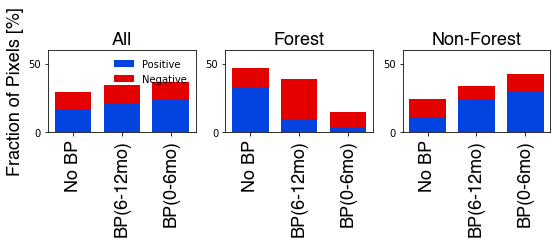

In [5]:
# count the fraction of pixels with no BP,  BP 0.5 - 1 year, BP < 0.5 year

# exclude pixels with nan values (non vegetation or low quality data)
# QUESTION: what does inf in Change_total mean?

data_mask = (
    (~np.isnan(bfast_all_df['Change_total'].values)) & 
    (~np.isinf(bfast_all_df['Change_total'].values)) &
    (bfast_all_df['Change_total'].values < 100.) &
    (bfast_all_df['Change_total'].values > -100.)
)

total_effects = bfast_all_df['Change_total'].values[data_mask]
bp_effects = bfast_all_df['Change_BP'].values[data_mask]
bp_nums = bfast_all_df['BP_num'].values[data_mask]
LC = bfast_all_df['LC'].values.astype(int)[data_mask]
bp_range = bfast_all_df['BP_Range'].values[data_mask]

fig, axes = plt.subplots(1,3,figsize=(9,3),sharex=True)

title_strs = ['All','Forest','Non-Forest']

LC = np.array(LC)
for i, ax in enumerate(axes):
    if i == 0:
        lc_mask = (LC >= 0) # all land cover
    elif i == 1:
        lc_mask = (LC == 1) | (LC == 8) 
        #lc_mask = np.logical_or((LC == 1),(LC == 8)) #(LC <= 5) # forest
    elif i == 2:
        lc_mask = (LC == 6) | (LC == 7) | (LC == 9) | (LC == 10)
        #lc_mask = np.logical_or(np.logical_or((LC == 6),(LC == 7)),np.logical_or((LC == 9),(LC == 10)))#(LC > 5)  # non-forest
        
    
    # No BP, Weak BP, Medium BP, Strong BP
    x_ticklabels = ['No BP','BP(6-12mo)','BP(0-6mo)']
    # separate postive and negative changes
    
    positive_num = [
        np.sum(lc_mask & (bp_nums == 0) & (total_effects >= 0.)),
        #np.sum(lc_mask & (bp_nums > 0.) & (bp_effects >= 0.) & (bp_range > 23)),
        np.sum(lc_mask & (bp_nums > 0.) & (bp_effects >= 0.) & (bp_range > 12) & (bp_range <= 23)),
        np.sum(lc_mask & (bp_nums > 0.) & (bp_effects >= 0.) & (bp_range <= 12))
    ]
    
    
    
    negative_num = [
        np.sum(lc_mask & (bp_nums == 0) & (total_effects < 0.)),
        #np.sum(lc_mask & (bp_nums > 0.) & (bp_effects < 0.) & (bp_range > 23)),
        np.sum(lc_mask & (bp_nums > 0.) & (bp_effects < 0.) & (bp_range > 12) & (bp_range <= 23)),
        np.sum(lc_mask & (bp_nums > 0.) & (bp_effects < 0.) & (bp_range <= 12))
    ]
    total_num = np.sum(positive_num) + np.sum(negative_num)
    
    positive_frac = [float(pos_data) / total_num * 100. for pos_data in positive_num]

    negative_frac = [float(neg_data) / total_num * 100. for neg_data in negative_num]
            
    bar_idx = np.arange(len(positive_frac))
    
    ax.bar(bar_idx,positive_frac,width=0.75,facecolor='xkcd:blue')
    ax.bar(bar_idx,negative_frac,width=0.75,bottom=positive_frac,facecolor='xkcd:red')
    
    if i == 0:
        ax.legend({"Positive" : "xkcd:blue",
                   "Negative" : "xkcd:red"},
                  loc='upper right',frameon=False)    
        ax.set_ylabel('Fraction of Pixels [%]',fontsize=18.,fontweight='bold', fontname='Helvetica')

    ax.set_xticks(bar_idx)
    ax.set_xticklabels(x_ticklabels,rotation=90,fontsize=18.,fontweight='bold', fontname='Helvetica')
        
    ax.set_ylim([0,60])
    ax.set_title(
        title_strs[i],fontsize=18.,fontweight='bold', fontname='Helvetica'
    )
    
plt.rc('ytick',labelsize=18)
plt.gcf().subplots_adjust(bottom=0.5)
#fig.tight_layout()
plt.show()
fig.savefig('/Volumes/XiYangBackUp/Projects/6.CalDrought/BarFigure_500m.png',format='png',dpi=600)

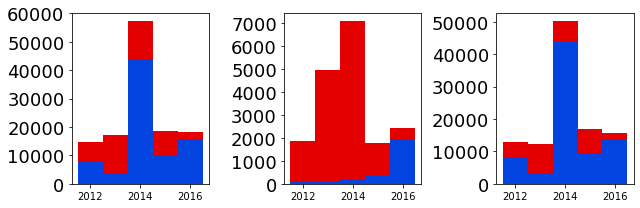

In [6]:
bp_effects = bfast_df['Change_BP'].values
LC = bfast_df['LC'].values.astype(int)
bp_range = bfast_df['BP_Range'].values
bp_time = bfast_df['BP1_year'].values
evi_lt = bfast_df['EVI_AVG'].values

fig, axes = plt.subplots(1,3,figsize=(9,3),sharex=True)

title_strs = ['All','Forest','Non-Forest']

for i, ax in enumerate(axes):
    if i == 0:
        lc_mask = (LC >= 0) # all land cover
    elif i == 1:
        lc_mask = (LC <= 5) # forest #(LC == 1) | (LC == 8)
    elif i == 2:
        lc_mask = (LC > 5)  # non-forest #(LC == 6) | (LC == 7) | (LC == 9) | (LC == 10)
        
    
    # only include medium and strong BP
    hist_data = [
        bp_time[(bp_effects >= 0.) & (bp_range < 23) & lc_mask & (evi_lt >= 0.15)],
        bp_time[(bp_effects < 0.) & (bp_range < 23) & lc_mask  & (evi_lt >= 0.15)],
                ]  
    
    ax.hist(hist_data,bins=np.arange(2012,2018),stacked=True,color=['xkcd:blue','xkcd:red'],align='left')
    #ax.set_xticklabels(['2012','2014','2016'],rotation=90,fontsize=18.,fontweight='bold', fontname='Helvetica')
    #if i == 0:
    #    ax.legend({"+ BP" : "xkcd:blue",
    #               "- BP" : "xkcd:red"},
    #              loc='upper right',frameon=False)
    #   ax.set_ylabel('# of Pixels',fontsize=18.,fontweight='bold', fontname='Helvetica')
    
    #ax.set_title(
    #    title_strs[i]
    #)
plt.rc('ytick',labelsize=4)
plt.rc('ytick',labelsize=4)
fig.tight_layout()
plt.show()
fig.savefig('/Volumes/XiYangBackUp/Projects/6.CalDrought/Fig.4A_500m.png',format='png',dpi=600)

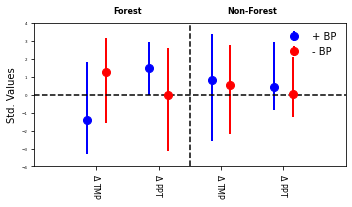

In [7]:
LC = bfast_df['LC'].values.astype(int)
lc_masks = [LC <= 5, #(LC == 1) | (LC == 8) 
            LC > 5, #(LC == 6) | (LC == 7) | (LC == 9) | (LC == 10)
           ]
bp_range = bfast_df['BP_Range'].values
bp_mask = (bp_range < 23) & (evi_lt >= 0.15)

# prepare data
pos_values = []
pos_cis = []

neg_values = []
neg_cis = []

var_names = ['TMP','PPT'] #,'SPEI'

pos_color = 'b'
neg_color = 'r'


for ilc, lc_mask in enumerate(lc_masks):
    for ivar, var_name in enumerate(var_names):
        # first pos
        data_mask = (bfast_df['Change_BP'].values >= 0.) & bp_mask & lc_mask
        data_array = (
            bfast_df[var_name+'ano_0011'].values[data_mask]
        -   bfast_df[var_name+'ano_1201'].values[data_mask]
            )
        nan_mask = ~np.isnan(data_array)
        if np.nansum(nan_mask) < 25:
            pos_values.append(np.nan)
            pos_cis.append([np.nan,np.nan])
        else:
            pos_values.append(np.nanmean(data_array))
            pos_cis.append(
                np.absolute(np.nanpercentile(data_array,[5.,95.])
                    - np.nanmean(data_array)
                ).tolist())

        # second neg
        data_mask = (bfast_df['Change_BP'].values < 0.) & bp_mask & lc_mask
        data_array = (
            bfast_df[var_name+'ano_0011'].values[data_mask]
        -   bfast_df[var_name+'ano_1201'].values[data_mask]
            )
        nan_mask = ~np.isnan(data_array)
        if np.nansum(nan_mask) < 25:
            neg_values.append(np.nan)
            neg_cis.append([np.nan,np.nan])
        else:
            neg_values.append(np.nanmean(data_array))
            neg_cis.append(
                np.absolute(
                    np.nanpercentile(data_array,[5.,95.])
                    - np.nanmean(data_array)
                ).tolist())


# plot figure

x_labels = [
            r'$\Delta$ TMP',
            r'$\Delta$ PPT',
            r'$\Delta$ TMP',
            r'$\Delta$ PPT',
]
           # r'$\Delta$ SPEI12', r'$\Delta$ SPEI12',
panel_x, panel_y = 1,1
fig, ax = plt.subplots(panel_x,panel_y,
                        figsize=(panel_y * 5.,panel_x * 3.))

# first plot positive
pos_idx = np.arange(len(pos_values)) - 0.15
ax.errorbar(pos_idx,pos_values,yerr=np.transpose(pos_cis),
            fmt='o',ecolor=pos_color,elinewidth=2.,color=pos_color,
            markersize=8.,mec=pos_color,mfc=pos_color,
            label=r'Positive $\delta$BP')

neg_idx = np.arange(len(pos_values)) + 0.15
ax.errorbar(neg_idx,neg_values,yerr=np.transpose(neg_cis),
            fmt='o',ecolor=neg_color,elinewidth=2.,color=neg_color,
            markersize=8.,mec=neg_color,mfc=neg_color,
            label=r'Negative $\delta$BP')

ax.legend({"+ BP" : "xkcd:blue",
           "- BP" : "xkcd:red"},
           loc='upper right',frameon=False)


xlim = (-1,len(pos_idx))
ax.set_xlim(xlim)
ylim = (-4.,4.)
ax.set_ylim(ylim)
ax.plot(xlim,(0.,0.),'k--',lw=1.5)


# separate two types
ylim = ax.get_ylim()
x_seps = [1.5]
for x_sep in x_seps:
    ax.plot([x_sep,x_sep],[ylim[0],ylim[1]],
            'k--',lw=1.5)

text_strs = ['Forest','Non-Forest']
text_xs = [.5,2.5]
# add text
for itext, (text_str, text_x) in enumerate(zip(text_strs,text_xs)):
    ax.text(text_x,1.05 * (ylim[1] - ylim[0])+ylim[0],
            text_str,fontsize=8,fontweight='bold',
            ha='center',va='bottom')

# add legend
ax.set_xticks(np.arange(len(pos_values)))
ax.set_xticklabels(x_labels,
                  fontsize=8.,rotation=-90,
                  va='top',ha='center')
ax.set_ylabel('Std. Values')

fig.tight_layout()
#fig.savefig('./Figure2.1.png',format='png',
#            dpi=300.)
plt.show()
fig.savefig('/Volumes/XiYangBackUp/Projects/6.CalDrought/Fig.4B_500m.png',format='png',dpi=600)

F
0.7986912829010213
NF
0.7891740368254755


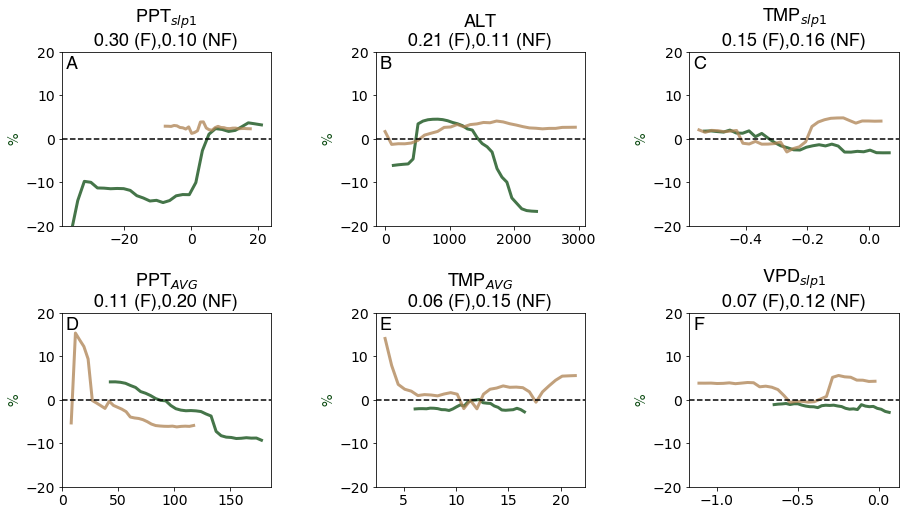

['TMP$_{slp1}$', 'PPT$_{slp1}$', 'VPD$_{slp1}$', 'EVI$_{lt}$', 'PPT$_{AVG}$', 'TMP$_{AVG}$', 'EVI$_{BP}', 'WTD', 'AWC', 'ALT', 'AWC_200', 'SOIL_DEPTH']
[0.15222569594300317, 0.29874348884729657, 0.07236600705311598, 0.017585924201441627, 0.10926634601176785, 0.064025224910454, 0.025009650885385662, 0.01599632936446931, 0.0062109651512038035, 0.21056141408367607, 0.015038180558832165, 0.01297077298935372]
[0.15584494037492058, 0.10301898072751187, 0.11971923794606464, 0.020240815481894166, 0.1971244613370268, 0.15415443809232127, 0.04592009312394428, 0.022157798086513008, 0.015333794983889955, 0.10563800203992817, 0.024658498445715413, 0.03618893936026971]


In [18]:
from sklearn.ensemble import RandomForestRegressor

LC = bfast_df['LC'].values.astype(int)
BP_num = bfast_df['BP_num'].values.astype(int)
sub_masks = [
     ((LC == 1) | (LC == 8)) & ~np.isnan(bfast_df['Change_postBP'].values) & bp_mask, #(LC <= 5) #(BP_num == 1) & (LC == 1) | (LC == 8)
     ((LC == 6) | (LC == 7) | (LC == 9) | (LC == 10)) & ~np.isnan(bfast_df['Change_postBP'].values) & bp_mask, #(LC > 5) #(BP_num == 1) & (LC == 6) | (LC == 7) | (LC == 9) | (LC == 10)
]
sub_names = ['F','NF']
y_var = 'Change_postBP'

# we need to first save the results
features = [
            'Tmano_slp1',
            'PPTano_slp1',
            'VPDano_slp1',
 #           'Tmano_3yr',
 #           'PPTano_3yr',
 #           'VPDano_3yr',
 #   'Change_preBP',
 #   'Change_BP',
            'EVI_AVG',
            'PPT_AVG',
            'TMP_AVG',
            'EVI_BP',
            'WTD',
            'AWC',
            'ALT',
            'AWC_200',
            'SOIL_DEPTH']

feature_names = [
    r'TMP$_{slp1}$',
    r'PPT$_{slp1}$',
    r'VPD$_{slp1}$',
#    r'TMP$_{post}$',
#    r'PPT$_{post}$',
#    r'VPD$_{post}$',
#    r'δ$_{pre}$',
#   r'δ$_{BP}$',
    r'EVI$_{lt}$',
    r'PPT$_{AVG}$',
    r'TMP$_{AVG}$',
    r'EVI$_{BP}',
    r'WTD',
    r'AWC',
    r'ALT',
    r'AWC_200',
    r'SOIL_DEPTH'
        ]

reg_importance_LC0 = []
pdp_x_vals_LC0 = []
pdp_y_vals_LC0 = []

reg_importance_LC1 = []
pdp_x_vals_LC1 = []
pdp_y_vals_LC1 = []


for isub, sub_mask in enumerate(sub_masks):

    rf_df = bfast_df[sub_mask]
    rf_X = rf_df[features].values
    rf_y = rf_df[y_var].values 

    regr = RandomForestRegressor(
                            min_samples_split=20,
                            n_estimators=200,oob_score=True)
    regr.fit(rf_X,rf_y)

    print(sub_names[isub])
    print(regr.oob_score_)

    # sort importance, most important to least
    sort_idx = np.argsort(regr.feature_importances_)[::-1]
    # store results
    if isub == 0:
        reg_importance_LC0.extend(regr.feature_importances_)

    elif isub == 1:
        reg_importance_LC1.extend(regr.feature_importances_)


    if isub < 2:

        pdp_x_vals = []
        pdp_y_vals = []
        for feature_idx, feature in enumerate(features):
            cur_feature = features[feature_idx]
            feature_name = feature_names[feature_idx]

            # get range
            x_min = np.nanpercentile(rf_X[:,feature_idx],1.)
            x_max = np.nanpercentile(rf_X[:,feature_idx],99.)
            x_step = (x_max - x_min) / 30.
            plot_x = np.arange(x_min,x_max,x_step)
            pdp_x_vals.append(plot_x)


            pdp_vals = np.zeros((len(plot_x),len(regr.estimators_))) * np.nan

            for ix, x_center in enumerate(plot_x):
                # use all data

                # select only the data from x_left to x_left + x_step
                # prepare pred_x
                pred_x = []
                for j, f in enumerate(features):
                    if j == feature_idx:
                        pred_x.append(np.ones_like(rf_X[:,j]) * x_center)
                    else:
                        pred_x.append(rf_X[:,j])
                pred_x = np.array(pred_x).T

                for iest, est in enumerate(regr.estimators_):
                    pdp_vals[ix,iest] = np.nanmean(est.predict(pred_x))

            pdp_y_vals.append(np.nanmean(pdp_vals,axis=1))

        if isub == 0:
            pdp_x_vals_LC0 += pdp_x_vals
            pdp_y_vals_LC0 += pdp_y_vals
        elif isub == 1:
            pdp_x_vals_LC1 += pdp_x_vals
            pdp_y_vals_LC1 += pdp_y_vals


# plot figure

sort_idx = np.argsort(
    np.array(reg_importance_LC0) + np.array(reg_importance_LC1))[::-1]

panel_x, panel_y = 2,3
fontsize=8.
fig5, axes5 = plt.subplots(panel_x,panel_y,
                           figsize=(panel_y*5,panel_x*4.),
                            sharey=False,sharex=False)
plt.subplots_adjust(None,None,None,None,0.5,0.5)
for i, ax in enumerate(axes5.ravel()):
    # plot forest in green
    # plot grass in light brown
    feature_idx= sort_idx[i]
    feature_name = feature_names[feature_idx]
    plot_x = pdp_x_vals_LC0[feature_idx]
    plot_y = pdp_y_vals_LC0[feature_idx]
    plot_color = 'xkcd:forest green'
    h1, = ax.plot(plot_x,plot_y,'-',lw=3.,color=plot_color,alpha=0.75,
                  label='Forest')

    ax.set_ylabel('%',fontsize=14.,fontweight='bold',color=plot_color, fontname='Helvetica')
    
    ax.tick_params(labelsize=14.)
    ax.set_ylim((-20,20))

#        ax2 = ax.twinx()
    plot_x = pdp_x_vals_LC1[feature_idx]
    plot_y = pdp_y_vals_LC1[feature_idx]
    plot_color = 'xkcd:light brown'
    h2, = ax.plot(plot_x,plot_y,'-',lw=3.,color=plot_color,alpha=0.75,
                  label='Non-Forest')
#        ax2.set_ylabel('%, Non-Forest',fontsize=7.,fontweight='bold',color=plot_color)
#        ax2.tick_params(labelsize=7.)
#        ax2.set_ylim((-60,20))


    ax.set_title('{:s}\n{:3.2f} (F),{:3.2f} (NF)'.format(
                    feature_name,
                    reg_importance_LC0[feature_idx],
                    reg_importance_LC1[feature_idx]),
                  fontsize=18.,fontweight='bold', fontname='Helvetica')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

#        xlim2 = ax2.get_xlim()

#        xlim = (np.minimum(xlim[0],xlim2[0]),
#                np.maximum(xlim[1],xlim2[1]))

    ax.set_xlim(xlim)
#        ax2.set_xlim(xlim)

    # zero line
    ax.plot(xlim,[0.,0.],'k--',2.)

    pn = chr(65 + i)
    ax.text(
        xlim[0] + 0.02 * (xlim[1] - xlim[0]),
        ylim[0] + 0.98 * (ylim[1] - ylim[0]),
        pn,
        ha='left',va='top',
        fontsize=18.,fontweight='bold', fontname='Helvetica'
            )

    #if i == 1:
    #    handles, legends = ax.get_legend_handles_labels()
    #    ax.legend(handles,legends,loc='lower left',ncol=1,frameon=False,
    #                fontsize=7)




#fig5.tight_layout(pad=0.2)
#fig5.savefig('./Figure5.png',format='png',
#            dpi=300.)
plt.show()
print(feature_names)
print(reg_importance_LC0)
print(reg_importance_LC1)
fig.savefig('/Volumes/XiYangBackUp/Projects/6.CalDrought/Fig.6_500m.png',format='png',dpi=600)

RF analysis of pre BP changes

F
0.8366385929253496
NF
0.9061655473650201


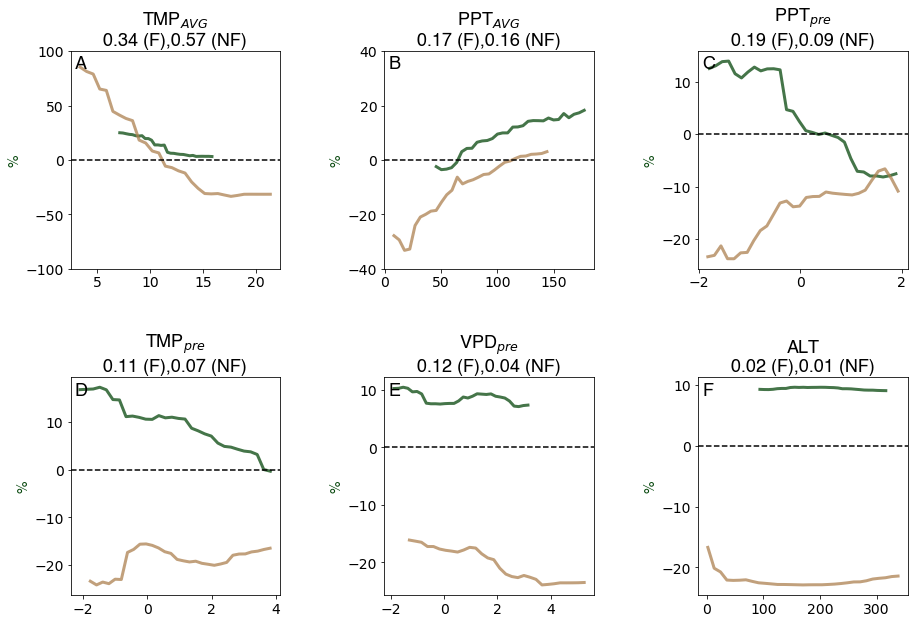

['TMP$_{pre}$', 'PPT$_{pre}$', 'VPD$_{pre}$', 'EVI$_{lt}$', 'PPT$_{AVG}$', 'TMP$_{AVG}$', 'WTD', 'AWC', 'ALT', 'AWC_200', 'SOIL_DEPTH']
[0.11144397696826741, 0.1932399623151848, 0.11908126237284977, 0.016704492203930846, 0.17327957828460772, 0.3384981122075797, 0.016617384601183508, 0.00937757361787941, 0.01703356302914034, 0.004724094399376458]
[0.06727453665219316, 0.09009990124269528, 0.040200191142791726, 0.009223420688714321, 0.16191865378195225, 0.572965607305395, 0.014305333123211776, 0.00951454254609712, 0.014250653251192309, 0.02024716026575696]


In [15]:
from sklearn.ensemble import RandomForestRegressor

LC = bfast_df['LC'].values.astype(int)
sub_masks = [ 
    (LC <= 5) & ~np.isnan(bfast_df['Change_preBP'].values) & bp_mask, #(LC == 1) | (LC == 8)
    (LC > 5) & ~np.isnan(bfast_df['Change_preBP'].values) & bp_mask, #(LC == 6) | (LC == 7) | (LC == 9) | (LC == 10)
]
sub_names = ['F','NF']
y_var = 'Change_preBP'

# we need to first save the results
features = [
            'Tmano_pre',
            'PPTano_pre',
            'VPDano_pre',
#            'TMPano_1201',
#            'PPTano_1201',
#            'VPDano_1201',
            'EVI_AVG',
            'PPT_AVG',
            'TMP_AVG',
            'WTD',
            'AWC',
#            'ALT',
            'AWC_200',
            'SOIL_DEPTH'
            ]

feature_names = [
    r'TMP$_{pre}$',
    r'PPT$_{pre}$',
    r'VPD$_{pre}$',
#    r'TMP$_{pre}$',
#    r'PPT$_{pre}$',
#    r'VPD$_{pre}$',
    r'EVI$_{lt}$',
    r'PPT$_{AVG}$',
    r'TMP$_{AVG}$',
    r'WTD',
    r'AWC',
    r'ALT',
    r'AWC_200',
    r'SOIL_DEPTH'
        ]

reg_importance_LC0 = []
pdp_x_vals_LC0 = []
pdp_y_vals_LC0 = []

reg_importance_LC1 = []
pdp_x_vals_LC1 = []
pdp_y_vals_LC1 = []


for isub, sub_mask in enumerate(sub_masks):

    rf_df = bfast_df[sub_mask]
    rf_X = rf_df[features].values
    rf_y = rf_df[y_var].values 

    regr = RandomForestRegressor(
                            min_samples_split=20,
                            n_estimators=200,oob_score=True)
    regr.fit(rf_X,rf_y)

    print(sub_names[isub])
    print(regr.oob_score_)

    # sort importance, most important to least
    sort_idx = np.argsort(regr.feature_importances_)[::-1]
    # store results
    if isub == 0:
        reg_importance_LC0.extend(regr.feature_importances_)

    elif isub == 1:
        reg_importance_LC1.extend(regr.feature_importances_)


    if isub < 2:

        pdp_x_vals = []
        pdp_y_vals = []
        for feature_idx, feature in enumerate(features):
            cur_feature = features[feature_idx]
            feature_name = feature_names[feature_idx]

            # get range
            x_min = np.nanpercentile(rf_X[:,feature_idx],1.)
            x_max = np.nanpercentile(rf_X[:,feature_idx],99.)
            x_step = (x_max - x_min) / 30.
            plot_x = np.arange(x_min,x_max,x_step)
            pdp_x_vals.append(plot_x)


            pdp_vals = np.zeros((len(plot_x),len(regr.estimators_))) * np.nan

            for ix, x_center in enumerate(plot_x):
                # use all data

                # select only the data from x_left to x_left + x_step
                # prepare pred_x
                pred_x = []
                for j, f in enumerate(features):
                    if j == feature_idx:
                        pred_x.append(np.ones_like(rf_X[:,j]) * x_center)
                    else:
                        pred_x.append(rf_X[:,j])
                pred_x = np.array(pred_x).T

                for iest, est in enumerate(regr.estimators_):
                    pdp_vals[ix,iest] = np.nanmean(est.predict(pred_x))

            pdp_y_vals.append(np.nanmean(pdp_vals,axis=1))

        if isub == 0:
            pdp_x_vals_LC0 += pdp_x_vals
            pdp_y_vals_LC0 += pdp_y_vals
        elif isub == 1:
            pdp_x_vals_LC1 += pdp_x_vals
            pdp_y_vals_LC1 += pdp_y_vals


# plot figure

sort_idx = np.argsort(
    np.array(reg_importance_LC0) + np.array(reg_importance_LC1))[::-1]

panel_x, panel_y = 2,3
fontsize=8.
fig5, axes5 = plt.subplots(panel_x,panel_y,
                           figsize=(panel_y*5,panel_x*5.),
                            sharey=False,sharex=False)
plt.subplots_adjust(None,None,None,None,0.5,0.5)
for i, ax in enumerate(axes5.ravel()):
    # plot forest in green
    # plot grass in light brown
    feature_idx= sort_idx[i]
    feature_name = feature_names[feature_idx]
    plot_x = pdp_x_vals_LC0[feature_idx]
    plot_y = pdp_y_vals_LC0[feature_idx]
    plot_color = 'xkcd:forest green'
    h1, = ax.plot(plot_x,plot_y,'-',lw=3.,color=plot_color,alpha=0.75,
                  label='Forest')

    ax.set_ylabel('%',fontsize=14.,fontweight='bold',color=plot_color, fontname='Helvetica')
    
    ax.tick_params(labelsize=14.)
    if i == 0:
        ax.set_ylim((-100,100))
    elif i == 1:
        ax.set_ylim((-40,40))
    

#        ax2 = ax.twinx()
    plot_x = pdp_x_vals_LC1[feature_idx]
    plot_y = pdp_y_vals_LC1[feature_idx]
    plot_color = 'xkcd:light brown'
    h2, = ax.plot(plot_x,plot_y,'-',lw=3.,color=plot_color,alpha=0.75,
                  label='Non-Forest')
#        ax2.set_ylabel('%, Non-Forest',fontsize=7.,fontweight='bold',color=plot_color)
#        ax2.tick_params(labelsize=7.)
#        ax2.set_ylim((-60,20))


    ax.set_title('{:s}\n{:3.2f} (F),{:3.2f} (NF)'.format(
                    feature_name,
                    reg_importance_LC0[feature_idx],
                    reg_importance_LC1[feature_idx]),
                  fontsize=18.,fontweight='bold', fontname='Helvetica')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

#        xlim2 = ax2.get_xlim()

#        xlim = (np.minimum(xlim[0],xlim2[0]),
#                np.maximum(xlim[1],xlim2[1]))

    ax.set_xlim(xlim)
#        ax2.set_xlim(xlim)

    # zero line
    ax.plot(xlim,[0.,0.],'k--',2.)

    pn = chr(65 + i)
    ax.text(
        xlim[0] + 0.02 * (xlim[1] - xlim[0]),
        ylim[0] + 0.98 * (ylim[1] - ylim[0]),
        pn,
        ha='left',va='top',
        fontsize=18.,fontweight='bold', fontname='Helvetica'
            )

    #if i == 1:
    #    handles, legends = ax.get_legend_handles_labels()
    #    ax.legend(handles,legends,loc='lower left',ncol=1,frameon=False,
    #                fontsize=7)




#fig5.tight_layout(pad=0.2)
#fig5.savefig('./Figure5.png',format='png',
#            dpi=300.)
plt.show()
print(feature_names)
print(reg_importance_LC0)
print(reg_importance_LC1)

RF analysis of Changes at BP

F
0.8835081175174221
NF
0.9276919572223737


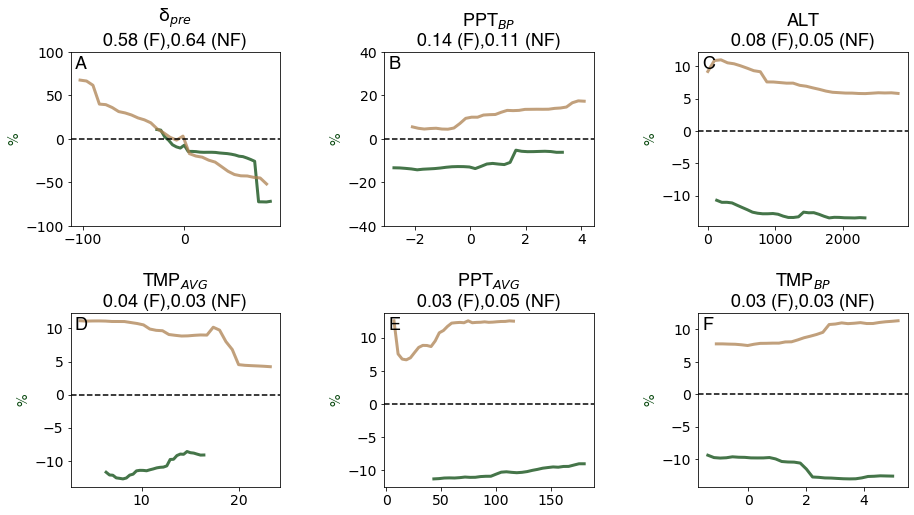

In [19]:
from sklearn.ensemble import RandomForestRegressor

LC = bfast_df['LC'].values.astype(int)
sub_masks = [
    (LC == 1) | (LC == 8) & ~np.isnan(bfast_df['Change_BP'].values) & bp_mask, #(LC == 1) | (LC == 8)
    (LC == 6) | (LC == 7) | (LC == 9) | (LC == 10) & ~np.isnan(bfast_df['Change_BP'].values) & bp_mask,
]
sub_names = ['F','NF']
y_var = 'Change_BP'

# we need to first save the results
features = [
            'TMPano_0011',
            'PPTano_0011',
            'VPDano_0011',
            'Change_preBP',
#            'TMPano_0606',
#            'PPTano_0606',
#            'VPDano_0606',
            'EVI_AVG',
            'PPT_AVG',
            'TMP_AVG',
            'WTD',
            'AWC',
            'ALT',
            'AWC_200',
            'SOIL_DEPTH']

feature_names = [
#    r'TMP$_{BP}$',
#    r'PPT$_{BP}$',
#    r'VPD$_{BP}$',
    r'TMP$_{BP}$',
    r'PPT$_{BP}$',
    r'VPD$_{BP}$',
    r'δ$_{pre}$',
    r'EVI$_{lt}$',
    r'PPT$_{AVG}$',
    r'TMP$_{AVG}$',
    r'WTD',
    r'AWC',
    r'ALT',
    r'AWC_200',
    r'SOIL_DEPTH',
        ]

reg_importance_LC0 = []
pdp_x_vals_LC0 = []
pdp_y_vals_LC0 = []

reg_importance_LC1 = []
pdp_x_vals_LC1 = []
pdp_y_vals_LC1 = []


for isub, sub_mask in enumerate(sub_masks):

    rf_df = bfast_df[sub_mask]
    rf_X = rf_df[features].values
    rf_y = rf_df[y_var].values 

    regr = RandomForestRegressor(
                            min_samples_split=20,
                            n_estimators=200,oob_score=True)
    regr.fit(rf_X,rf_y)

    print(sub_names[isub])
    print(regr.oob_score_)

    # sort importance, most important to least
    sort_idx = np.argsort(regr.feature_importances_)[::-1]
    # store results
    if isub == 0:
        reg_importance_LC0.extend(regr.feature_importances_)

    elif isub == 1:
        reg_importance_LC1.extend(regr.feature_importances_)


    if isub < 2:

        pdp_x_vals = []
        pdp_y_vals = []
        for feature_idx, feature in enumerate(features):
            cur_feature = features[feature_idx]
            feature_name = feature_names[feature_idx]

            # get range
            x_min = np.nanpercentile(rf_X[:,feature_idx],1.)
            x_max = np.nanpercentile(rf_X[:,feature_idx],99.)
            x_step = (x_max - x_min) / 30.
            plot_x = np.arange(x_min,x_max,x_step)
            pdp_x_vals.append(plot_x)


            pdp_vals = np.zeros((len(plot_x),len(regr.estimators_))) * np.nan

            for ix, x_center in enumerate(plot_x):
                # use all data

                # select only the data from x_left to x_left + x_step
                # prepare pred_x
                pred_x = []
                for j, f in enumerate(features):
                    if j == feature_idx:
                        pred_x.append(np.ones_like(rf_X[:,j]) * x_center)
                    else:
                        pred_x.append(rf_X[:,j])
                pred_x = np.array(pred_x).T

                for iest, est in enumerate(regr.estimators_):
                    pdp_vals[ix,iest] = np.nanmean(est.predict(pred_x))

            pdp_y_vals.append(np.nanmean(pdp_vals,axis=1))

        if isub == 0:
            pdp_x_vals_LC0 += pdp_x_vals
            pdp_y_vals_LC0 += pdp_y_vals
        elif isub == 1:
            pdp_x_vals_LC1 += pdp_x_vals
            pdp_y_vals_LC1 += pdp_y_vals


# plot figure

sort_idx = np.argsort(
    np.array(reg_importance_LC0) + np.array(reg_importance_LC1))[::-1]

panel_x, panel_y = 2,3
fontsize=8.
fig5, axes5 = plt.subplots(panel_x,panel_y,
                           figsize=(panel_y*5,panel_x*4),
                            sharey=False,sharex=False)
plt.subplots_adjust(None,None,None,None,0.5,0.5)

for i, ax in enumerate(axes5.ravel()):
    # plot forest in green
    # plot grass in light brown
    feature_idx= sort_idx[i]
    feature_name = feature_names[feature_idx]
    plot_x = pdp_x_vals_LC0[feature_idx]
    plot_y = pdp_y_vals_LC0[feature_idx]
    plot_color = 'xkcd:forest green'
    h1, = ax.plot(plot_x,plot_y,'-',lw=3.,color=plot_color,alpha=0.75,
                  label='Forest')

    ax.set_ylabel('%',fontsize=14.,fontweight='bold',color=plot_color, fontname='Helvetica')
    
    ax.tick_params(labelsize=14.)
    if i == 0:
        ax.set_ylim((-100,100))
    elif i == 1:
        ax.set_ylim((-40,40))

#        ax2 = ax.twinx()
    plot_x = pdp_x_vals_LC1[feature_idx]
    plot_y = pdp_y_vals_LC1[feature_idx]
    plot_color = 'xkcd:light brown'
    h2, = ax.plot(plot_x,plot_y,'-',lw=3.,color=plot_color,alpha=0.75,
                  label='Non-Forest')
#        ax2.set_ylabel('%, Non-Forest',fontsize=7.,fontweight='bold',color=plot_color)
#        ax2.tick_params(labelsize=7.)
#        ax2.set_ylim((-60,20))


    ax.set_title('{:s}\n{:3.2f} (F),{:3.2f} (NF)'.format(
                    feature_name,
                    reg_importance_LC0[feature_idx],
                    reg_importance_LC1[feature_idx]),
                  fontsize=18.,fontweight='bold', fontname='Helvetica')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

#        xlim2 = ax2.get_xlim()

#        xlim = (np.minimum(xlim[0],xlim2[0]),
#                np.maximum(xlim[1],xlim2[1]))

    ax.set_xlim(xlim)
#        ax2.set_xlim(xlim)

    # zero line
    ax.plot(xlim,[0.,0.],'k--',2.)

    pn = chr(65 + i)
    ax.text(
        xlim[0] + 0.02 * (xlim[1] - xlim[0]),
        ylim[0] + 0.98 * (ylim[1] - ylim[0]),
        pn,
        ha='left',va='top',
        fontsize=18.,fontweight='bold', fontname='Helvetica'
            )

    #if i == 1:
    #    handles, legends = ax.get_legend_handles_labels()
    #    ax.legend(handles,legends,loc='lower left',ncol=1,frameon=False,
    #                fontsize=7)




#fig5.tight_layout(pad=0.2)
#fig5.savefig('./Figure5.png',format='png',
#            dpi=300.)
plt.show()


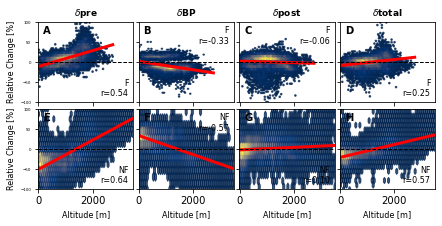

In [17]:
data_names = ['Change_preBP','Change_BP','Change_postBP','Total_postBP']
plot_names = [
        r'$\delta$pre',
        r'$\delta$BP',
        r'$\delta$post',
        r'$\delta$total']

panel_x, panel_y = len(lcs), len(data_names)

fig, axes = plt.subplots(panel_x,panel_y,figsize=(6.,panel_x* 1.5),
                      sharex=True,sharey=True)
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        data_name = data_names[j]
        plot_name = plot_names[j]
        lc = lcs[i]
        data_mask = lc_masks[i] & bp_mask

        plot_x = bfast_df['ALT'].values[data_mask]
        plot_data = bfast_df[data_name].values[data_mask] 
        ax.hexbin(plot_x,plot_data,gridsize=50,mincnt=1,cmap=mpl.cm.cividis,alpha=0.75)

        # linear regression
        res = sm.OLS(plot_data,sm.add_constant(plot_x)).fit()
        coef, p = pearsonr(plot_data,plot_x)
        if p < 0.05:
            ls = '-'
        else:
            ls = '--'
        intercept,slope = res.params

        line_x = np.array([np.nanmin(plot_x),
                            np.nanmax(plot_x)])

        line_y = intercept + slope * line_x
        ax.plot(line_x,line_y,lw=3.,ls=ls,c='r')

        # plot zero line
        line_x = np.array([-5,3500.])
        line_y = np.zeros_like(line_x)
        ax.plot(line_x,line_y,lw=1.,ls='--',c='k')

        ax.set_ylim((-100.,100.))
        ax.set_yticks([-100,-50,0,50,100])
        ax.set_xlim((-5,3500.))

        if i == panel_x - 1:
            ax.set_xlabel('Altitude [m]',fontsize=8.)
        if j == 0:
            ax.set_ylabel('Relative Change [%]',fontsize=8)
        if i == 0:
            ax.set_title(plot_name,fontsize=9,fontweight='bold')

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if coef > 0:
            ax.text(
                xlim[0] + 0.95 * (xlim[1] - xlim[0]),
                ylim[0] + 0.05 * (ylim[1] - ylim[0]),
                lc + '\nr={:4.2f}'.format(coef),
                ha='right',va='bottom',fontsize=8
                   )
        else:
            ax.text(
                xlim[0] + 0.95 * (xlim[1] - xlim[0]),
                ylim[0] + 0.95 * (ylim[1] - ylim[0]),
                lc + '\nr={:4.2f}'.format(coef),
                ha='right',va='top',fontsize=8
                   )

        pn = chr(65+i*4+j)
        ax.text(
            xlim[0] + 0.05 * (xlim[1] - xlim[0]),
            ylim[0] + 0.95 * (ylim[1] - ylim[0]),
            pn,ha='left',va='top',fontsize=10,
            fontweight='bold'
                )


fig.tight_layout(pad=0.2)
#fig.savefig('./Figure3.png',format='png',
#            dpi=300)
plt.show()